In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.io import wavfile
import os.path
import IPython.display
import seaborn as sns
import librosa
import librosa.display
import soundfile

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from keras import optimizers


# Load the data
import pandas as pd
df = pd.read_csv("C:\\Users\\mohsi\\Downloads\\archive\\valid\\_annotations.csv")
df.head()



,filename,width,height,class,xmin,ymin,xmax,ymax
0,0355_jpg.rf.e3e6daab192a51e715ef9fc3394f2a76.jpg,512,256,Fillings,186,85,209,129
1,0355_jpg.rf.e3e6daab192a51e715ef9fc3394f2a76.jpg,512,256,Fillings,167,93,188,128
2,0355_jpg.rf.e3e6daab192a51e715ef9fc3394f2a76.jpg,512,256,Fillings,143,93,170,130
3,0355_jpg.rf.e3e6daab192a51e715ef9fc3394f2a76.jpg,512,256,Fillings,127,132,155,182
4,0355_jpg.rf.e3e6daab192a51e715ef9fc3394f2a76.jpg,512,256,Implant,313,85,330,123


In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  780 non-null    object
 1   width     780 non-null    int64 
 2   height    780 non-null    int64 
 3   class     780 non-null    object
 4   xmin      780 non-null    int64 
 5   ymin      780 non-null    int64 
 6   xmax      780 non-null    int64 
 7   ymax      780 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 48.9+ KB
None


The annotation data have multiple rows for one image means that one image contain more that one classes
After getting the corresponding cropped image according to a unique row and corresponding image the size will be different so there is a need to filter low area images for further processing as there are images with 0 area such that either width or height is zero

In [11]:
# Assuming df_valid is a DataFrame that has been defined previously
df['cropped_image_width'] = df['xmax'] - df['xmin']
df['cropped_image_height'] = df['ymax'] - df['ymin']
df['Area'] = df['cropped_image_width'] * df['cropped_image_height']
df['Area'] = df['cropped_image_width']*df['cropped_image_height']
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,cropped_image_width,cropped_image_height,Area
0,0355_jpg.rf.e3e6daab192a51e715ef9fc3394f2a76.jpg,512,256,Fillings,186,85,209,129,23,44,1012
1,0355_jpg.rf.e3e6daab192a51e715ef9fc3394f2a76.jpg,512,256,Fillings,167,93,188,128,21,35,735
2,0355_jpg.rf.e3e6daab192a51e715ef9fc3394f2a76.jpg,512,256,Fillings,143,93,170,130,27,37,999
3,0355_jpg.rf.e3e6daab192a51e715ef9fc3394f2a76.jpg,512,256,Fillings,127,132,155,182,28,50,1400
4,0355_jpg.rf.e3e6daab192a51e715ef9fc3394f2a76.jpg,512,256,Implant,313,85,330,123,17,38,646


There is a need to select the optimum area threshold to select only certain images because if the low area image is resized to a reasonably high resoution it will disturb the analysis

In [13]:
df.columns

Index(['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax',
       'cropped_image_width', 'cropped_image_height', 'Area'],
      dtype='object')

In [14]:
# Filter the Data to select the interquartile data only(Area 25th to 75th percentile)
# You may use different range but obective is to not include the minimum areas

df = df[(df.Area >= df.Area.quantile(0.25)) & (df.Area <= df.Area.quantile(0.75))]

Repeat procedure for train and test

In [15]:
df_test = pd.read_csv('C:\\Users\\mohsi\\Downloads\\archive\\test\\_annotations.csv')
# There is a need to find the optimum width and heigth of cropped image
df_test['cropped_image_width'] = df_test['xmax']-df_test['xmin']
df_test['cropped_image_height'] = df_test['ymax']-df_test['ymin']
df_test['Area'] = df_test['cropped_image_width']*df_test['cropped_image_height']

# Filter the Data to select the interquartile data only(Area 25th to 75th percentile)
# You may use different range but obective is to not include the minimum areas

df_test = df_test[(df_test.Area >= df_test.Area.quantile(0.25)) & (df_test.Area <= df_test.Area.quantile(0.75))]
df_test.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,cropped_image_width,cropped_image_height,Area
5,0136_jpg.rf.03e2aec8ec77594665dd1abc68d47bd3.jpg,512,256,Fillings,164,158,195,197,31,39,1209
8,0136_jpg.rf.03e2aec8ec77594665dd1abc68d47bd3.jpg,512,256,Fillings,331,111,354,150,23,39,897
9,0136_jpg.rf.03e2aec8ec77594665dd1abc68d47bd3.jpg,512,256,Fillings,310,110,332,152,22,42,924
10,0136_jpg.rf.03e2aec8ec77594665dd1abc68d47bd3.jpg,512,256,Fillings,185,111,204,152,19,41,779
13,0507_jpg.rf.07ca548c6eb4f61c76f1629e7bc26fa4.jpg,512,256,Fillings,251,91,272,148,21,57,1197


In [16]:
df_train = pd.read_csv('C:\\Users\\mohsi\\Downloads\\archive\\train\\_annotations.csv')

# There is a need to find the optimum width and heigth of cropped image
df_train['cropped_image_width'] = df_train['xmax']-df_train['xmin']
df_train['cropped_image_height'] = df_train['ymax']-df_train['ymin']
df_train['Area'] = df_train['cropped_image_width']*df_train['cropped_image_height']
# Filter the Data to select the interquartile data only(Area 25th to 75th percentile)
# You may use different range but obective is to not include the minimum areas

df_train = df_train[(df_train.Area >= df_train.Area.quantile(0.25)) & (df_train.Area <= df_train.Area.quantile(0.75))]
df_train.head()


,filename,width,height,class,xmin,ymin,xmax,ymax,cropped_image_width,cropped_image_height,Area
0,0674_jpg.rf.e02a155a0c135687b9301ff9a20d220a.jpg,512,256,Implant,175,116,206,153,31,37,1147
3,0674_jpg.rf.e02a155a0c135687b9301ff9a20d220a.jpg,512,256,Implant,302,126,329,175,27,49,1323
4,0674_jpg.rf.e02a155a0c135687b9301ff9a20d220a.jpg,512,256,Implant,335,114,360,154,25,40,1000
7,0674_jpg.rf.e02a155a0c135687b9301ff9a20d220a.jpg,512,256,Fillings,311,58,330,109,19,51,969
13,0271_jpg.rf.e18d2d727c6d0c029f5b6024f39058d6.jpg,512,256,Fillings,140,114,161,164,21,50,1050


handling mising values

In [17]:
df_train.isnull().sum()

filename                0
width                   0
height                  0
class                   0
xmin                    0
ymin                    0
xmax                    0
ymax                    0
cropped_image_width     0
cropped_image_height    0
Area                    0
dtype: int64

images processing 

In [22]:
dirname = r'C:\\Users\\mohsi\\Downloads\\archive\\test'
filenames = [filename for filename in os.listdir(dirname) if filename.endswith(".jpg")]
image_list = []
label_list = []
# Define the desired image size
desired_width = 50
desired_height = 50
for filename in filenames:
    img_df = df_test[df_test.filename == filename]
    image = cv2.imread(os.path.join(dirname,filename))
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Iterate over each row in the dataframe
    for index, row in img_df.iterrows():
        # Extract crop parameters
        xmin = row['xmin']
        xmax = row['xmax']
        ymin = row['ymin']
        ymax = row['ymax']
        # Crop the image
        cropped_image = gray_image[ymin:ymax, xmin:xmax]
        # Resize the cropped image
        resized_image = cv2.resize(cropped_image, (desired_width, desired_height))
        image_list.append(resized_image)
        label_list.append(row['class'])
image_list_test = np.array(image_list)
label_list_test = np.array(label_list)
print(image_list_test.shape)
print(label_list_test.shape)

(237, 50, 50)
(237,)


In [24]:
dirname = 'C:\\Users\\mohsi\\Downloads\\archive\\valid'
filenames = [filename for filename in os.listdir(dirname) if filename.endswith(".jpg")]
image_list = []
label_list = []
# Define the desired image size
desired_width = 50
desired_height = 50
for filename in filenames:
    img_df = df[df.filename == filename]
    image = cv2.imread(os.path.join(dirname,filename))
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Iterate over each row in the dataframe
    for index, row in img_df.iterrows():
        # Extract crop parameters
        xmin = row['xmin']
        xmax = row['xmax']
        ymin = row['ymin']
        ymax = row['ymax']
        # Crop the image
        cropped_image = gray_image[ymin:ymax, xmin:xmax]
        # Resize the cropped image
        resized_image = cv2.resize(cropped_image, (desired_width, desired_height))
        image_list.append(resized_image)
        label_list.append(row['class'])
image_list_valid = np.array(image_list)
label_list_valid = np.array(label_list)
print(image_list_valid.shape)
print(label_list_valid.shape)

(392, 50, 50)
(392,)


In [25]:
dirname = 'C:\\Users\\mohsi\\Downloads\\archive\\train'
filenames = [filename for filename in os.listdir(dirname) if filename.endswith(".jpg")]
image_list = []
label_list = []
# Define the desired image size
desired_width = 50
desired_height = 50
for filename in filenames:
    img_df = df_train[df_train.filename == filename]
    image = cv2.imread(os.path.join(dirname,filename))
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Iterate over each row in the dataframe
    for index, row in img_df.iterrows():
        # Extract crop parameters
        xmin = row['xmin']
        xmax = row['xmax']
        ymin = row['ymin']
        ymax = row['ymax']
        # Crop the image
        cropped_image = gray_image[ymin:ymax, xmin:xmax]
        # Resize the cropped image
        resized_image = cv2.resize(cropped_image, (desired_width, desired_height))
        image_list.append(resized_image)
        label_list.append(row['class'])
image_list_train = np.array(image_list)
label_list_train = np.array(label_list)
print(image_list_train.shape)
print(label_list_train.shape)

(4023, 50, 50)
(4023,)


one hot encoding

In [26]:
from sklearn.preprocessing import OneHotEncoder
# Create an instance of the OneHotEncoder
encoder = OneHotEncoder()

# Reshape the label array to be a column vector
labels_reshaped = label_list_train.reshape(-1, 1)

# Fit and transform the label array using the OneHotEncoder
one_hot_encoded = encoder.fit_transform(labels_reshaped)

# Convert the sparse matrix to a dense array
one_hot_encoded_array = one_hot_encoded.toarray()

lable_y_train = one_hot_encoded_array

In [27]:
encoder = OneHotEncoder()

# Reshape the label array to be a column vector
labels_reshaped = label_list_test.reshape(-1, 1)

# Fit and transform the label array using the OneHotEncoder
one_hot_encoded = encoder.fit_transform(labels_reshaped)

# Convert the sparse matrix to a dense array
one_hot_encoded_array = one_hot_encoded.toarray()

lable_y_test = one_hot_encoded_array

In [28]:
encoder = OneHotEncoder()

# Reshape the label array to be a column vector
labels_reshaped = label_list_valid.reshape(-1, 1)

# Fit and transform the label array using the OneHotEncoder
one_hot_encoded = encoder.fit_transform(labels_reshaped)

# Convert the sparse matrix to a dense array
one_hot_encoded_array = one_hot_encoded.toarray()

lable_y_valid = one_hot_encoded_array

lable_y_valid.shape

(392, 4)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Assuming you have input train data with shape (4023, 50, 50) and corresponding labels with shape (4023, 4)
train_data =  image_list_train # Replace this with your actual train data
train_labels = lable_y_train  # Replace this with your actual train labels
valid_data = image_list_valid
valid_labels = lable_y_valid
# Define the model architecture
model = tf.keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(50, 50, 1)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')
])


# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_data, train_labels, epochs=50, batch_size=32, validation_data=(valid_data,valid_labels))

In [30]:
predicted_classes = model.predict(image_list_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [31]:
set(label_list_test)

{'Cavity', 'Fillings', 'Impacted Tooth', 'Implant'}

In [32]:
predicted_labels = np.argmax(predicted_classes, axis=1)

# Map class labels to class names
class_names = ['Cavity', 'Fillings', 'Impacted Tooth', 'Implant']
predicted_class_names = [class_names[label] for label in predicted_labels]

# Print the predicted class names
print(predicted_class_names)


['Implant', 'Implant', 'Impacted Tooth', 'Implant', 'Fillings', 'Implant', 'Implant', 'Impacted Tooth', 'Impacted Tooth', 'Impacted Tooth', 'Fillings', 'Fillings', 'Fillings', 'Fillings', 'Implant', 'Implant', 'Implant', 'Implant', 'Implant', 'Fillings', 'Fillings', 'Cavity', 'Fillings', 'Impacted Tooth', 'Fillings', 'Implant', 'Fillings', 'Cavity', 'Cavity', 'Fillings', 'Fillings', 'Fillings', 'Fillings', 'Fillings', 'Impacted Tooth', 'Impacted Tooth', 'Fillings', 'Implant', 'Implant', 'Implant', 'Fillings', 'Fillings', 'Fillings', 'Fillings', 'Fillings', 'Implant', 'Fillings', 'Fillings', 'Fillings', 'Fillings', 'Fillings', 'Fillings', 'Fillings', 'Implant', 'Fillings', 'Fillings', 'Fillings', 'Fillings', 'Impacted Tooth', 'Fillings', 'Fillings', 'Impacted Tooth', 'Implant', 'Impacted Tooth', 'Fillings', 'Fillings', 'Fillings', 'Fillings', 'Fillings', 'Fillings', 'Fillings', 'Fillings', 'Fillings', 'Implant', 'Implant', 'Implant', 'Implant', 'Fillings', 'Fillings', 'Cavity', 'Implant

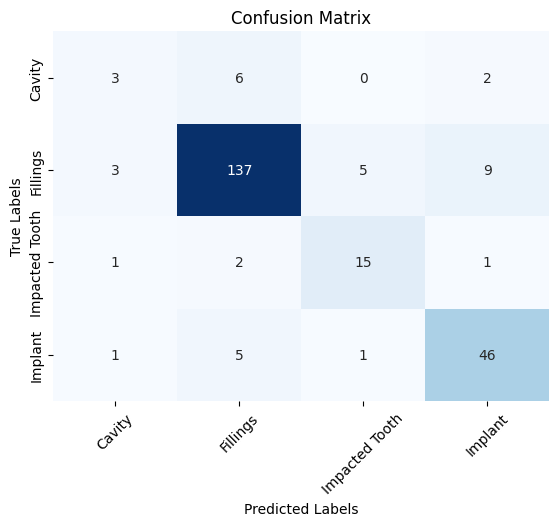

In [33]:
from sklearn.metrics import confusion_matrix


# Compute the confusion matrix
cm = confusion_matrix(label_list_test, predicted_class_names)

# Define class names (adjust according to your specific class names)
class_names = ['Cavity', 'Fillings', 'Impacted Tooth', 'Implant']

# Create a figure and axis
fig, ax = plt.subplots()

# Create a heatmap from the confusion matrix
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)

# Set axis labels and title
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

# Set x-axis tick labels
heatmap.set_xticklabels(class_names)
heatmap.set_yticklabels(class_names)

# Rotate x-axis tick labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.show()
